# Introduction to Bayesian Modeling with Python
We follow the tutorial from http://nbviewer.jupyter.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%200.%20Introduction.ipynb and use the python library https://github.com/pymc-devs/pymc3

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

from datetime import datetime

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [41]:
# Import json data
with open('data/hangouts.json') as json_file:
    json_data = json.load(json_file)

# Generate map from gaia_id to real name
def user_name_mapping(data):
    user_map = {'gaia_id': ''}
    for state in data['conversation_state']:
        participants = state['conversation_state']['conversation']['participant_data']
        for participant in participants:
            if 'fallback_name' in participant:
                user_map[participant['id']['gaia_id']] = participant['fallback_name']

    return user_map

user_dict = user_name_mapping(json_data)

# Parse data into flat list
def fetch_messages(data):
    messages = []
    for state in data['conversation_state']:
        conversation_state = state['conversation_state']
        conversation = conversation_state['conversation']
        conversation_id = conversation_state['conversation']['id']['id']
        participants = conversation['participant_data']

        all_participants = []
        for participant in participants:
            if 'fallback_name' in participant:
                user = participant['fallback_name']
            else:
                # Scope to call G+ API to get name
                user = participant['id']['gaia_id']
            all_participants.append(user)
            num_participants = len(all_participants)
        
        for event in conversation_state['event']:
            try:
                sender = user_dict[event['sender_id']['gaia_id']]
            except:
                sender = event['sender_id']['gaia_id']
            
            timestamp = datetime.fromtimestamp(float(float(event['timestamp'])/10**6.))
            event_id = event['event_id']

            if 'chat_message' in event:
                content = event['chat_message']['message_content']
                if 'segment' in content:
                    segments = content['segment']
                    for segment in segments:
                        if 'text' in segment:
                            message = segment['text']
                            message_length = len(message)
                            message_type = segment['type']
                            if len(message) > 0:
                                messages.append((conversation_id,
                                                 event_id, 
                                                 timestamp, 
                                                 sender, 
                                                 message,
                                                 message_length,
                                                 all_participants,
                                                 ', '.join(all_participants),
                                                 num_participants,
                                                 message_type))

    messages.sort(key=lambda x: x[0])
    return messages

# Parse data into data frame
cols = ['conversation_id', 'event_id', 'timestamp', 'sender', 
        'message', 'message_length', 'participants', 'participants_str', 
        'num_participants', 'message_type']

messages = pd.DataFrame(fetch_messages(json_data), columns=cols).sort(['conversation_id', 'timestamp'])

/Users/rio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:75: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [42]:
# Engineer features
messages['prev_timestamp'] = messages.groupby(['conversation_id'])['timestamp'].shift(1)
messages['prev_sender'] = messages.groupby(['conversation_id'])['sender'].shift(1)

# Exclude messages are are replies to oneself (not first reply)
messages = messages[messages['sender'] != messages['prev_sender']]

# Time delay
messages['time_delay_seconds'] = (messages['timestamp'] - messages['prev_timestamp']).astype('timedelta64[s]')
messages = messages[messages['time_delay_seconds'].notnull()]
messages['time_delay_mins'] = np.ceil(messages['time_delay_seconds'].astype(int)/60.0)

# Time attributes
messages['day_of_week'] = messages['timestamp'].apply(lambda x: x.dayofweek)
messages['year_month'] = messages['timestamp'].apply(lambda x: x.strftime("%Y-%m"))
messages['is_weekend'] = messages['day_of_week'].isin([5,6]).apply(lambda x: 1 if x == True else 0)

# Limit to messages sent by me and exclude all messages between me and Alison
# messages = messages[(messages['sender'] == 'Mark Regan') & (messages['participants_str'] != 'Alison Darcy, Mark Regan')]

# Remove messages not responded within 60 seconds
# This introduces an issue by right censoring the data (might return to address)
# messages = messages[messages['time_delay_seconds'] < 60]

messages.head(1)

,conversation_id,event_id,timestamp,sender,message,message_length,participants,participants_str,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
2,Ugw2ec0xQWP-qbDAMKd4AaABAQ,7-H0Z7-Rz4T7-H0gzvash_,2013-10-08 13:14:28.493134,Noel Moreno Lemus,hola maricela,13,"[seo.msuarez@gmail.com, Noel Moreno Lemus]","seo.msuarez@gmail.com, Noel Moreno Lemus",2,TEXT,2013-10-08 13:14:21.080270,seo.msuarez@gmail.com,7.0,1.0,1,2013-10,0


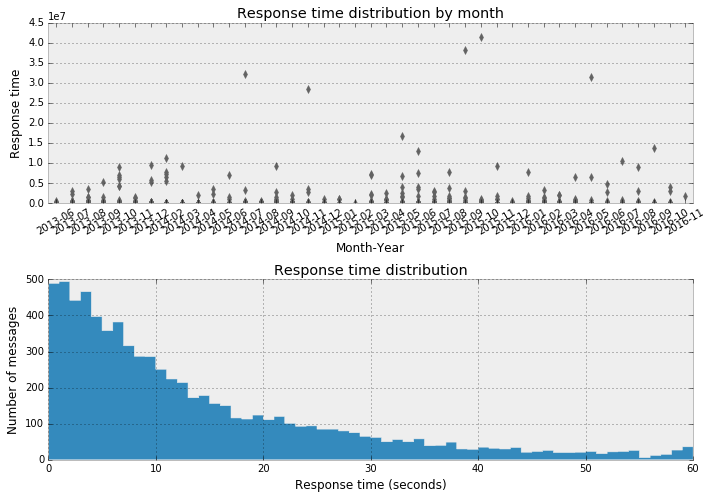

In [43]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(211)

order = np.sort(messages['year_month'].unique())
sns.boxplot(x=messages['year_month'], y=messages['time_delay_seconds'], order=order, orient="v", color=colors[5], linewidth=1, ax=ax)
_ = ax.set_title('Response time distribution by month')
_ = ax.set_xlabel('Month-Year')
_ = ax.set_ylabel('Response time')
_ = plt.xticks(rotation=30)

ax = fig.add_subplot(212)
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled', color=colors[0])
_ = ax.set_title('Response time distribution')
_ = ax.set_xlabel('Response time (seconds)')
_ = ax.set_ylabel('Number of messages')

plt.tight_layout()

In [44]:
# excluded some colums from csv output
messages.drop(['participants', 'message', 'participants_str'], axis=1, inplace=True)

# Save csv to data folder
messages.to_csv('data/hangout_chat_data.csv', index=False)

# Estimating model parameters

In [61]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangouts.csv')

# How do Bayesians think about data?

When I started to learn how to apply Bayesian methods, I found it very useful to understand how Bayesians think about data. Imagine the following scenario:

A curious boy watches the number of cars that pass by his house every day. He diligently notes down the total count of cars that pass per day. Over the past week, his notebook contains the following counts: 12, 33, 20, 29, 20, 30, 18
From a Bayesian's perspective, this data is generated by a random process. However, now that the data is observed, it is fixed and does not change. This random process has some model parameters that are fixed. However, the Bayesian uses probability distributions to represent his/her uncertainty in these parameters.

Because the boy is measuring counts (non-negative integers), it is common practice to use a Poisson distribution to model the data (eg. the random process). A Poisson distribution takes a single parameter μ which describes both the mean and variance of the data. You can see 3 Poisson distributions below with different values of μ.

$$p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for     } 
x = 0, 1, 2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$

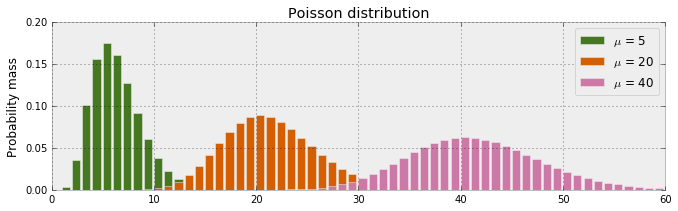

In [46]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

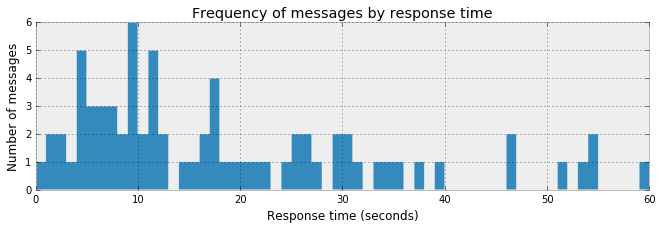

In [62]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

## Frequentists method of estimating  μ

In [48]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 70035.4923946
CPU times: user 57 µs, sys: 16 µs, total: 73 µs
Wall time: 76.1 µs


In [49]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [00:34<00:00, 5878.57it/s]


In [52]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [00:46<00:00, 4279.88it/s]


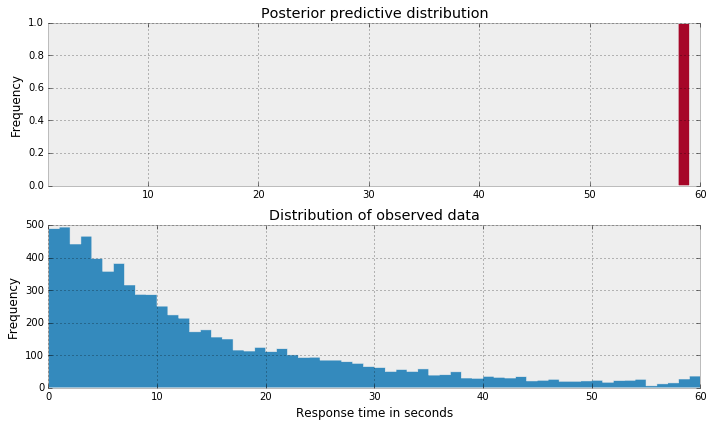

In [53]:
x_lim = 60
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [63]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=100)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [01:27<00:00, 2289.49it/s]


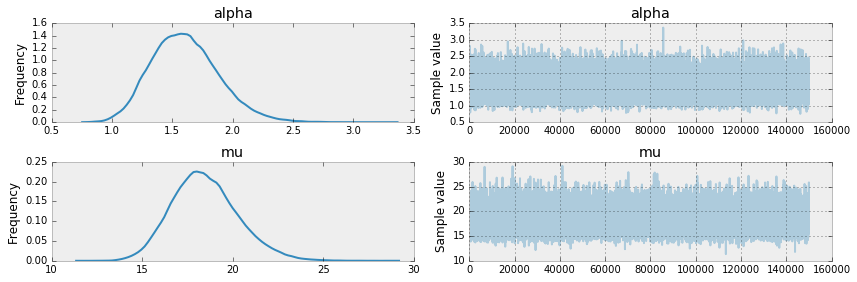

In [64]:
_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

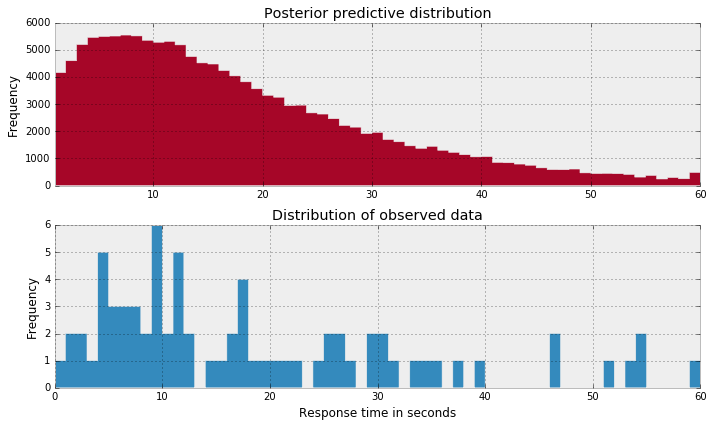

In [65]:
x_lim = 60
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

array([0, 0, 0, ..., 0, 0, 0])